In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Função para dividir a imagem em patches
def divide_image_into_patches(image, patch_size):
    patches = []
    positions = []

    # Dimensões da imagem
    height, width = image.shape[:2]

    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            # Extrair o patch
            patch = image[i:i + patch_size, j:j + patch_size]

            # Preencher com zeros, se necessário
            padded_patch = np.zeros((patch_size, patch_size, *image.shape[2:]), dtype=image.dtype)
            padded_patch[:patch.shape[0], :patch.shape[1]] = patch

            patches.append(padded_patch)
            positions.append((i, j))

    return np.array(patches), positions

# Função para reconstruir a imagem a partir dos patches
def reconstruct_image_from_patches(patches, positions, image_shape, patch_size):
    # Criar a matriz para a imagem reconstruída
    reconstructed_image = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.uint8)

    for patch, (i, j) in zip(patches, positions):
        # Dimensões do patch
        patch_height, patch_width = patch.shape[:2]

        # Coordenadas de destino ajustadas
        end_i = min(i + patch_height, image_shape[0])
        end_j = min(j + patch_width, image_shape[1])

        # Coordenadas da área do patch a ser usada
        patch_i_end = end_i - i
        patch_j_end = end_j - j

        # Inserir apenas a parte válida do patch
        reconstructed_image[i:end_i, j:end_j] = patch[:patch_i_end, :patch_j_end]

    return reconstructed_image

# Função para classificar e pintar patches
def classify_and_color_patches(patches, model, class_to_color):
    colored_patches = []

    for patch in patches:
        # Expandir dimensões para compatibilidade com o modelo
        input_patch = np.expand_dims(patch, axis=0)

        # Obter a classe prevista
        prediction = model.predict(input_patch, verbose=0)
        class_index = np.argmax(prediction)

        # Obter a cor correspondente
        class_name = list(class_to_color.keys())[class_index]
        color = class_to_color[class_name]  # Obter o RGB associado

        # Criar um patch colorido com a cor correspondente
        colored_patch = np.full((patch.shape[0], patch.shape[1], 3), color, dtype=np.uint8)
        colored_patches.append(colored_patch)

    return np.array(colored_patches)

In [2]:
# Mapeamento de cores para classes
color_to_class = {
    (0, 175, 239): 'agua',
    (255, 242, 18): 'bacia sedimentar',
    (132, 113, 107): 'crosta continental',
    (245, 134, 52): 'crosta oceanica',
    (136, 160, 172): 'manto'
}

class_to_color = {v: k for k, v in color_to_class.items()}

patch_size = 64
model = load_model('/kaggle/input/modelo/modelo_treinado_new.h5')
image = np.load('/kaggle/input/mecosegmentation/Oliveira/BB08RE11-210-PRCMIG.npy')

# Dividir a imagem em patches
patches, positions = divide_image_into_patches(image, patch_size)

In [4]:
# Classificar e colorir os patches
colored_patches = classify_and_color_patches(patches, model, class_to_color)

In [6]:
# Reconstruir a imagem segmentada
segmented_image = reconstruct_image_from_patches(colored_patches, positions, image.shape, patch_size)

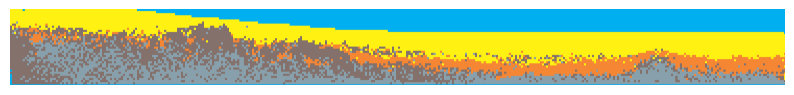

In [7]:
# Exibir a imagem segmentada
plt.figure(figsize=(10, 10))
plt.imshow(segmented_image)
plt.savefig('segmented_image_newmodel.png', bbox_inches='tight', pad_inches=0)  # Salvar como arquivo PNG
plt.axis('off')
plt.show()

## Testando com a janela deslizante

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import load_model

# Função para dividir a imagem em patches com janela deslizante
def divide_image_into_patches(image, patch_size, stride):
    patches = []
    positions = []
    height, width = image.shape[:2]

    for i in range(0, height - patch_size + 1, stride):
        for j in range(0, width - patch_size + 1, stride):
            patch = image[i:i + patch_size, j:j + patch_size]
            patches.append(patch)
            positions.append((i, j))

    return np.array(patches), positions

# Função para reconstruir a imagem segmentada com média dos patches sobrepostos
def reconstruct_image_from_patches(patches, positions, image_shape, patch_size, stride):
    reconstructed_image = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.float32)
    count_matrix = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.float32)  

    for patch, (i, j) in zip(patches, positions):
        reconstructed_image[i:i + patch_size, j:j + patch_size] += patch
        count_matrix[i:i + patch_size, j:j + patch_size] += 1  

    reconstructed_image /= np.maximum(count_matrix, 1)
    return reconstructed_image.astype(np.uint8)

# Função para classificar e colorir patches
def classify_and_color_patches(patches, model, class_to_color):
    colored_patches = []
    
    start_time = time.time()  # Início da medição

    for patch in patches:
        input_patch = np.expand_dims(patch, axis=0)
        prediction = model.predict(input_patch, verbose=0)
        class_index = np.argmax(prediction)

        class_name = list(class_to_color.keys())[class_index]
        color = class_to_color[class_name]

        colored_patch = np.full((patch.shape[0], patch.shape[1], 3), color, dtype=np.uint8)
        colored_patches.append(colored_patch)

    end_time = time.time()  # Fim da medição
    total_time = end_time - start_time  # Tempo total de inferência

    # Número total de pixels processados
    total_pixels = len(patches) * (patches.shape[1] * patches.shape[2])

    # Tempo médio por pixel
    time_per_pixel = total_time / total_pixels if total_pixels > 0 else 0

    print(f"Tempo total de inferência: {total_time:.4f} segundos")
    print(f"Tempo médio por pixel: {time_per_pixel:.8f} segundos")

    return np.array(colored_patches)

In [35]:
# Mapeamento de cores para classes
color_to_class = {
    (0, 175, 239): 'agua',
    (255, 242, 18): 'bacia sedimentar',
    (132, 113, 107): 'crosta continental',
    (245, 134, 52): 'crosta oceanica',
    (136, 160, 172): 'manto'
}
class_to_color = {v: k for k, v in color_to_class.items()}

# Parâmetros do modelo
patch_size = 64
stride = patch_size // 2  # Janela deslizante com 50% de sobreposição

# Carregar modelo e imagem
model = load_model('/kaggle/input/mecosegmentation/Oliveira/modelo_treinado2.h5')
image = np.load('/kaggle/input/mecosegmentation/Oliveira/BB08RE11-210-PRCMIG.npy')

# Extrair patches com sobreposição
patches, positions = divide_image_into_patches(image, patch_size, stride)

In [ ]:
# Classificar e colorir os patches
colored_patches = classify_and_color_patches(patches, model, class_to_color)

In [ ]:
# Reconstruir a imagem segmentada
segmented_image = reconstruct_image_from_patches(colored_patches, positions, image.shape, patch_size, stride)

In [ ]:
# Exibir a imagem segmentada
plt.figure(figsize=(10, 10))
plt.imshow(segmented_image)
plt.axis('off')
plt.savefig('segmented_image_oldmodel1.png', bbox_inches='tight', pad_inches=0)
plt.show()